# Applied AI Assignment 2
## Team Members :
Name : Shriram Balaji

Student Id : 201751796

##  Step 1: Importing necessary Packages/Libraries 


In [91]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import string
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import time
import seaborn as sns
import os
"""from google.colab import drive
drive.mount('/content/drive')"""
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



##  Step 2: Loading Dataset
### 2.1 Calling the Pathway where dataset is saved

In [92]:
# After mounting, adjust the file paths
"""train_data_path = '/content/drive/My Drive/emnist-balanced-train.csv'
test_data_path = '/content/drive/My Drive/emnist-balanced-test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)"""
train_data = pd.read_csv(r'E:\Downloads\archive\emnist-balanced-train.csv')
test_data = pd.read_csv(r'E:\Downloads\archive\emnist-balanced-test.csv')

### 2.2 Creating Custom EMNIST dataset

In [93]:
# Transformation for normalization
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [94]:
# Custom Dataset Class
class CustomEMNIST(Dataset):
    def __init__(self, data, transform=None):
        self.labels = data.iloc[:, 0].values
        self.images = data.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


### Step 3: Splitting Dataset into Training and Testing Set

In [95]:
# Load datasets
train_dataset = CustomEMNIST(train_data, transform=transform)
test_dataset = CustomEMNIST(test_data, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 3.1 Understanding Dataset

In [96]:
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

Number of training samples: 112799
Number of testing samples: 18799


##  Step 5: Finding the best parameters for the models and training the best model

##  5.1 Defining The Models


### 5.1.1 MLP Model
> A multi-layer perceptron (MLP) model is a type of artificial neural network that consists of an input layer, one or more hidden
This is a simple implementation of Multi-Layer Perceptron (MLP) model using PyTorch library in Python. 

In [97]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation=nn.ReLU, dropout=0.0, batch_norm=False):
        super(MLP, self).__init__()
        layers = [nn.Flatten()]
        for idx, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(input_size if idx == 0 else hidden_sizes[idx-1], hidden_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(activation())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



### 5.1.2 CNN Model
> A  Convolutional Neural Network (CNN) is a type of neural network that is particularly well-suited to processing data with a grid for Image Classification

In [98]:
class CNN(nn.Module):
    def __init__(self, output_size, activation=nn.ReLU, dropout=0.0, batch_norm=False):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            activation(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32) if batch_norm else nn.Identity(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            activation(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64) if batch_norm else nn.Identity()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            activation(),
            nn.Dropout(dropout),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

### 5.2 Setting Device in which model is run

In [99]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 5.3 Function Definitions
> In this assignment, there are many necessary step so multiple functions are defined to  perform different tasks like training the model, evaluating the model, finding the best configuration to train the model in and visualising the output

### 5.3.1 train_model Function
> This function  is used to train the model using training data. It takes eight parameters: model, train_loader, optimizer, criterion, scheduler, device, l1_lambda and n_epochs


In [100]:
def train_model(model, train_loader, optimizer, criterion, scheduler, device, l1_lambda=0.0, n_epochs=10):
    train_losses, train_accuracies = [], []
    start_time = time.time()
    for epoch in range(n_epochs):
        model.train()  # Ensure model is in training mode
        running_loss, running_correct, total_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            # Apply L1 regularization manually
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_correct += (output.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_accuracy = running_correct / total_samples  # Fractional accuracy

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Print accuracy as a percentage for easier interpretation
        print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%')

        # Update the learning rate
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch_loss)
        else:
            scheduler.step()

        # Early stopping if the accuracy is less than 60% after the first epoch
        if epoch == 0 and epoch_accuracy < 0.70:
            print("Stopping training early due to low accuracy.")
            break

    total_time = time.time() - start_time
    print(f'Training completed in {total_time:.2f} seconds')
    return train_losses, train_accuracies


### 5.3.2 evaluate_model Function
> This  function evaluates the performance of a given model on test data. It takes in four parameters: model, test_loader, criterion and device.

In [101]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())  # Ensure tensor is moved to cpu before converting to numpy
            all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total  # Keep accuracy as a fraction
        print(f"Loss: {total_loss / len(test_loader):.4f}, Accuracy: {accuracy * 100:.2f}%")  # Print accuracy as a percentage

        # Calculate and print classification metrics
        print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(47)], zero_division=0))

        return accuracy


## 5.3.3 exploration_function Function
> This function is used to explore all the possible combination of parameters, optimizers and regularizations to find the best combination for the given model and dataset.

In [102]:
def exploration_function(model_type, train_loader, test_loader, device):
    activations = [nn.ReLU, nn.LeakyReLU, nn.ELU]
    optimizers_info = [
        (optim.SGD, 0.01),
        (optim.Adam, 0.001),
        (optim.RMSprop, 0.01)
    ]
    batch_normalization = [True, False]
    regularization_configs = [
        {"l1": 0.0, "l2": 0.0},
        {"l1": 0.01, "l2": 0.0},
        {"l1": 0.0, "l2": 0.01}
    ]
    dropouts = [0.0, 0.2]
    schedulers = ['StepLR', 'ReduceLROnPlateau']

    if model_type == "mlp":
        hidden_sizes = [(128, 64, 32), (256, 128)]
    else:
        hidden_sizes = [None]

    best_accuracy = 0.0
    best_config = {}
    for hidden_size in hidden_sizes:
        for Activation in activations:
            for optimizer_class, lr in optimizers_info:
                for use_bn in batch_normalization:
                    for reg_config in regularization_configs:
                        for dropout_p in dropouts:
                            for scheduler_name in schedulers:
                                # Initialize the correct model
                                if model_type == "mlp":
                                    model = MLP(784, hidden_size, 47, Activation, dropout_p, use_bn)
                                    print(hidden_size, Activation, optimizer_class, lr, use_bn,reg_config,dropout_p, scheduler_name)
                                elif model_type == "cnn":
                                    model = CNN(47, Activation, dropout_p, use_bn)
                                    print(Activation, optimizer_class, lr, use_bn,reg_config,dropout_p, scheduler_name)
                                model.to(device)

                                # Initialize the optimizer with L2 regularization if applicable
                                optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=reg_config['l2'])

                                # Define the scheduler
                                if scheduler_name == 'StepLR':
                                    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
                                elif scheduler_name == 'ReduceLROnPlateau':
                                    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

                                criterion = nn.CrossEntropyLoss()
                                # Train the model
                                train_losses, train_accuracies = train_model(model, train_loader, optimizer, criterion, scheduler, device, l1_lambda=reg_config['l1'], n_epochs=2)
                                if train_accuracies and train_accuracies[-1] > 0.70:
                                    test_accuracy = evaluate_model(model, test_loader, criterion, device)
                                    if test_accuracy > best_accuracy:
                                        best_accuracy = test_accuracy
                                        best_config = {
                                            "model_type": model_type,
                                            "hidden_size": hidden_size,
                                            "activation": Activation.__name__,
                                            "optimizer": optimizer_class.__name__,
                                            "lr": lr,
                                            "use_bn": use_bn,
                                            "dropout_p": dropout_p,
                                            "scheduler": scheduler_name,
                                            "l1": reg_config['l1'],
                                            "l2": reg_config['l2']
                                        }

    # After Exploration
    print("Best Configuration:", best_config)
    return best_config


### 5.3.4 train_optimised_model Function
> This function's purpose is to take the best configuration that we obtained and create the best  model using it. It will then save this model, call the plot_metrics funtion to plot the model training graph and finally call the evaluate_model function to evaluate the model.

In [105]:
def train_optimised_model(best_config):
    Activation = getattr(nn, best_config["activation"])
    
    if best_config["model_type"] == "mlp":
        model = MLP(784, best_config["hidden_size"], 47, Activation, best_config["dropout_p"], best_config["use_bn"])
    elif best_config["model_type"] == "cnn":
        model = CNN(47, Activation, best_config["dropout_p"], best_config["use_bn"])
    criterion = nn.CrossEntropyLoss()
    # Mapping string names to optimizer classes
    optimizers = {
        'Adam': optim.Adam,
        'SGD': optim.SGD,
        'RMSprop': optim.RMSprop
    }
    model.to(device)
    optimizer_class = optimizers.get(best_config["optimizer"])  # Default to Adam if not found
    optimizer = optimizer_class(model.parameters(), lr=best_config["lr"], weight_decay=best_config["l2"])
    if best_config["scheduler"] == 'StepLR':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    elif best_config["scheduler"] == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    train_losses, train_accuracies = train_model(model, train_loader, optimizer, criterion, scheduler, device, l1_lambda=best_config['l1'], n_epochs=10)
    plot_metrics(train_losses, train_accuracies, title="MLP Training" if best_config["model_type"] == "mlp" else "CNN Training")
    accuracy = evaluate_model(model,test_loader,criterion, device)
    return model, accuracy


### 5.3.5 visualise_predictions Function
> This function takes the best model, test data and number of samples to visualise the output we get from the 

In [85]:
# Function to predict and visualise top six samples from the test set
def visualise_predictions(model, data_loader,label_to_char, num_samples=6):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 6))
    for i in range(num_samples):
        ax = axes[i] if num_samples > 1 else axes
        image = images[i].cpu().squeeze()  # Move image to cpu and remove any singleton dimensions
        pred_label = label_to_char.get(preds[i].item(), "Unknown")
        true_label = label_to_char.get(labels[i].item(), "Unknown")
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Pred: {pred_label}, True: {true_label}')
        ax.axis('off')
    plt.show()

### 5.3.6 visualise_samples Function
> This function is used to visualise the dataset for our understanding

In [58]:
# Visualization of the dataset samples
def visualise_samples(dataset,label_to_char, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
    for i, (image, label) in enumerate(zip(dataset.images, dataset.labels)):
        if i >= num_samples:
            break
        ax = axes[i]
        image = image.reshape(28, 28)  # Assuming image is a flat array
        ax.imshow(image, cmap='gray')
        ax.title.set_text(f'Label: {label_to_char[label]}')
        ax.axis('off')
    plt.show()

### 5.3.7 plot_metrics Function
> The plot_metrics function is used to plot the train losses and train accuracy for each epoch  during training of a model on the training dataset.

In [86]:
def plot_metrics(train_losses, train_accuracies, title="Model Training"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Loss')
    plt.title(title + ' Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'ro-', label='Accuracy')
    plt.title(title + ' Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


### 5.3.8 print_metrics Function
>  This functions purpose is to  display the metrics of a given model and also plot the confusion matrix for that model.

In [87]:
# Function to calculate and print confusion matrix and classification metrics
def print_metrics(model, data_loader, average_method='macro'):
    y_pred, y_true = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))  # Larger figure size for better readability
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_method)
    recall = recall_score(y_true, y_pred, average=average_method)
    f1 = f1_score(y_true, y_pred, average=average_method)
    print("Classification Metrics")
    print("Accuracy: {:4f}".format(accuracy))
    print("Precision: {:4f}".format(precision))
    print("Recall: {:4f}".format(recall))
    print("F1 Score: {:4f}\n".format(f1))
    

### 5.3.9 load_label_mapping Function
> To map the labels of  the dataset to characters , you can use the load_label_mapping function

In [88]:

def load_label_mapping(filename):
    label_map = {}
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:
                label = int(parts[0])
                char = chr(int(parts[1]))  # Convert ASCII code to character
                label_map[label] = char
    return label_map

mapping_path = r"E:\Downloads\archive\emnist-balanced-mapping.txt" 
label_to_char = load_label_mapping(mapping_path)

### 5.4 Visualise Dataset
> The dataset is visualised here using the visualise_samples function

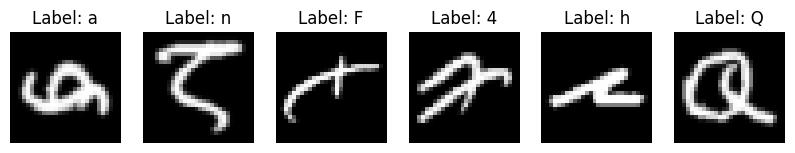

In [71]:
visualise_samples(train_dataset,label_to_char)


## 6 Finding the best combination of hyperparameters and techniques
> Using the exploration_function we can find the best hyperparameters and techniques for the required model by passing the model name, train data and device

### 6.1 For MLP model

In [ ]:
print("for mlp model")
best_mlp_config = exploration_function("mlp",train_loader,test_loader,device)

### 6.1.2 Training the best MLP model and evaluating it

Epoch 1/10, Loss: 0.8564, Accuracy: 74.95%
Epoch 2/10, Loss: 0.5193, Accuracy: 82.52%
Epoch 3/10, Loss: 0.4516, Accuracy: 84.37%
Epoch 4/10, Loss: 0.4131, Accuracy: 85.42%
Epoch 5/10, Loss: 0.3854, Accuracy: 86.25%
Epoch 6/10, Loss: 0.3643, Accuracy: 86.83%
Epoch 7/10, Loss: 0.3449, Accuracy: 87.27%
Epoch 8/10, Loss: 0.3288, Accuracy: 87.85%
Epoch 9/10, Loss: 0.3121, Accuracy: 88.26%
Epoch 10/10, Loss: 0.3017, Accuracy: 88.62%
Training completed in 372.20 seconds


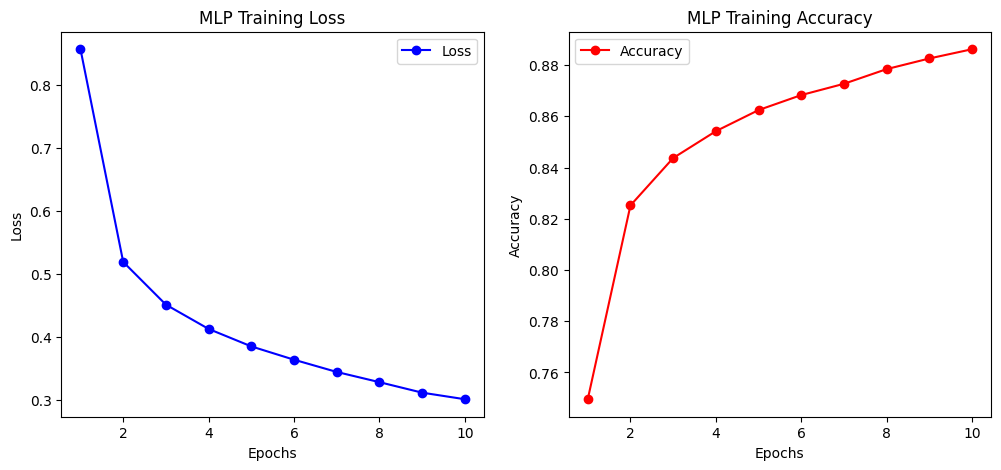

Loss: 0.4712, Accuracy: 84.99%
              precision    recall  f1-score   support

           0       0.62      0.79      0.70       400
           1       0.50      0.83      0.62       400
           2       0.77      0.92      0.84       400
           3       0.97      0.93      0.95       400
           4       0.91      0.86      0.88       400
           5       0.88      0.83      0.85       400
           6       0.95      0.84      0.89       400
           7       0.94      0.96      0.95       400
           8       0.90      0.90      0.90       400
           9       0.67      0.76      0.71       400
          10       0.95      0.94      0.94       400
          11       0.94      0.89      0.91       400
          12       0.95      0.92      0.94       400
          13       0.90      0.90      0.90       400
          14       0.96      0.94      0.95       400
          15       0.73      0.44      0.55       400
          16       0.91      0.92      0.92       

In [106]:
mlp_model, mlp_accuracy = train_optimised_model(best_mlp_config)

### 6.2 For CNN model

In [ ]:
print("For cnn Model")
best_cnn_config = exploration_function("cnn",train_loader,test_loader,device)


### 6.2.2 Training the best CNN model and evaluating it

Epoch 1/10, Loss: 0.5335, Accuracy: 82.37%
Epoch 2/10, Loss: 0.3459, Accuracy: 87.58%
Epoch 3/10, Loss: 0.2912, Accuracy: 88.99%
Epoch 4/10, Loss: 0.2546, Accuracy: 90.14%
Epoch 5/10, Loss: 0.2229, Accuracy: 91.12%
Epoch 6/10, Loss: 0.1986, Accuracy: 91.97%
Epoch 7/10, Loss: 0.1772, Accuracy: 92.71%
Epoch 8/10, Loss: 0.1566, Accuracy: 93.46%
Epoch 9/10, Loss: 0.1427, Accuracy: 94.10%
Epoch 10/10, Loss: 0.1282, Accuracy: 94.66%
Training completed in 569.86 seconds


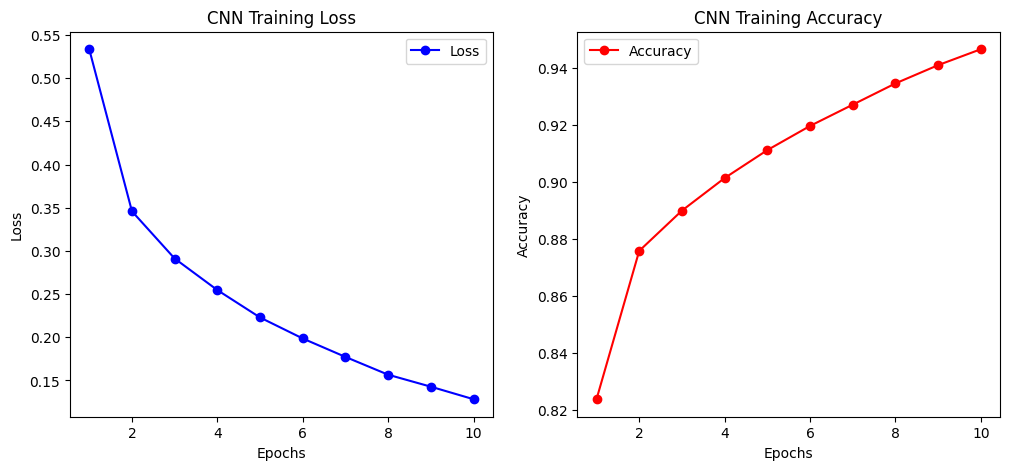

Loss: 0.5586, Accuracy: 86.51%
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       400
           1       0.55      0.62      0.58       400
           2       0.87      0.90      0.88       400
           3       0.97      0.97      0.97       400
           4       0.92      0.93      0.92       400
           5       0.91      0.88      0.90       400
           6       0.92      0.92      0.92       400
           7       0.96      0.99      0.98       400
           8       0.93      0.93      0.93       400
           9       0.69      0.80      0.74       400
          10       0.91      0.97      0.94       400
          11       0.97      0.93      0.95       400
          12       0.95      0.96      0.96       400
          13       0.94      0.86      0.90       400
          14       0.97      0.95      0.96       400
          15       0.67      0.59      0.63       400
          16       0.90      0.94      0.92       

In [107]:
cnn_model, cnn_accuracy= train_optimised_model(best_cnn_config)

### 6.3 Visualing Prediction Results

Visualizing MLP Predictions:


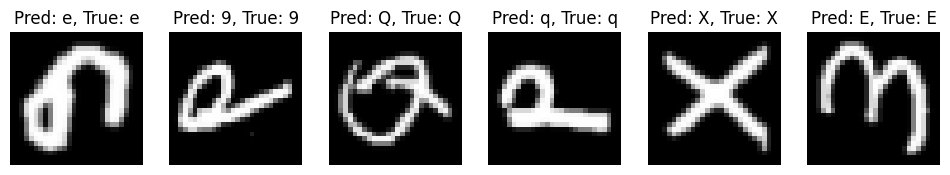

Visualizing CNN Predictions:


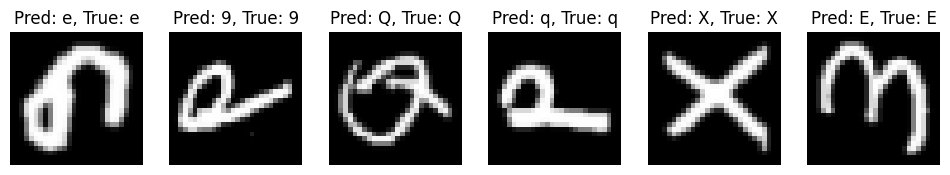

In [108]:
print("Visualizing MLP Predictions:")
visualise_predictions(mlp_model, test_loader,label_to_char)
print("Visualizing CNN Predictions:")
visualise_predictions(cnn_model, test_loader,label_to_char)

### 6.4 Printing Confusion Matrix and Performance metrics

Metrics for MLP:


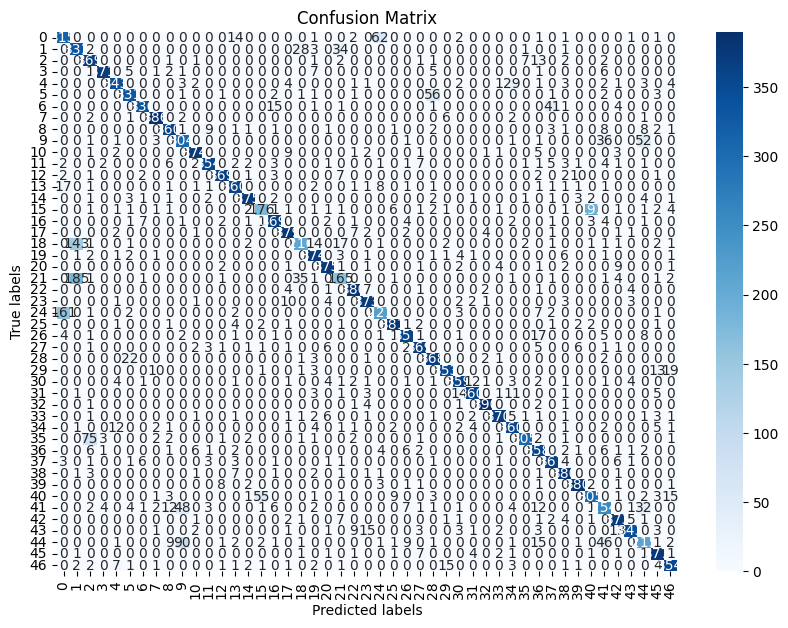

Classification Metrics
Accuracy: 0.849939
Precision: 0.855308
Recall: 0.849927
F1 Score: 0.848187

Metrics for CNN:


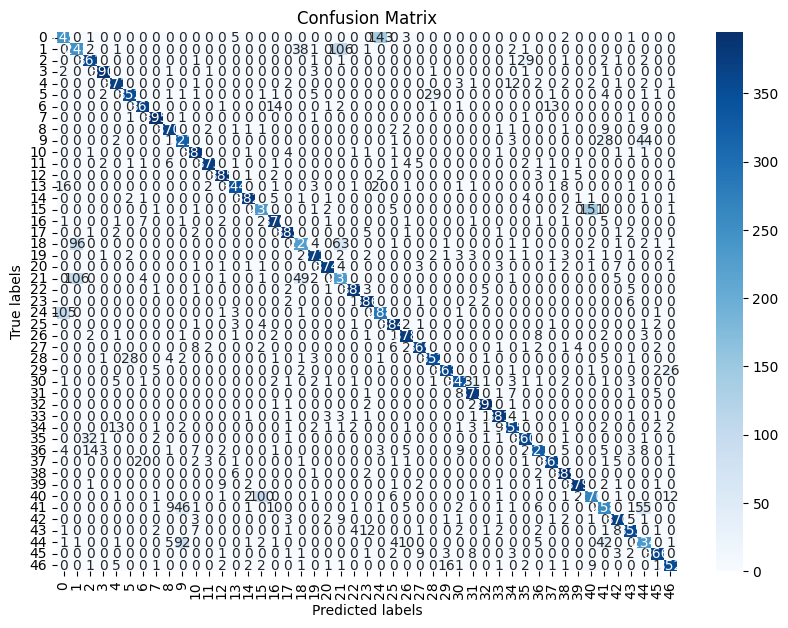

Classification Metrics
Accuracy: 0.865099
Precision: 0.866458
Recall: 0.865088
F1 Score: 0.864978



In [109]:
print("Metrics for MLP:")
print_metrics(mlp_model, test_loader)
print("Metrics for CNN:")
print_metrics(cnn_model, test_loader)

### 6.5 Comparison of Both Models

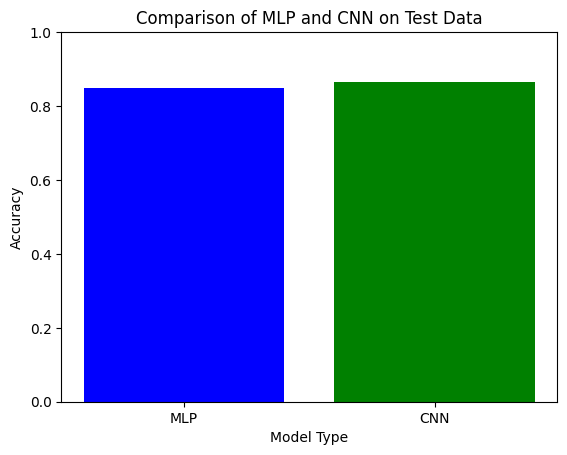

In [110]:
# Plotting the accuracies for visual comparison
plt.bar(['MLP', 'CNN'], [mlp_accuracy, cnn_accuracy], color=['blue', 'green'])
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Comparison of MLP and CNN on Test Data')
plt.ylim([0, 1])  # Adjust y-axis limits for better visual representation
plt.show()